In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join("..", "..", "..")))
import pysgmcmc as pg

## 1. Instantiating a Sampler

To instantiate a sampler, we need two ingredients:

1. Target parameters of the sampler: a list of `tensorflow.Variable` objects 
2. A cost function: callable that maps these target parameters to a 1-d `tensorflow.Tensor` representing their corresponding costs

Note: In MCMC literature, the target parameters are often denoted as $\theta$ and the cost function is frequently referred to as $U(\theta)$.

In [2]:
# target parameters
parameters = [tf.Variable(0.), tf.Variable(0.)]

# cost function
def banana_nll(params):
    x, y = params
    return -1./2. * (x ** 2 / 100. + (y + 0.1 * x ** 2 -10) ** 2)

Given these ingredients, we can instantiate any of our samplers within a `tensorflow.Session`:

In [3]:
from pysgmcmc.samplers.sghmc import SGHMCSampler

session = tf.Session()

sampler = SGHMCSampler(
    params=parameters, cost_fun=banana_nll, session=session, dtype=tf.float32
)

session.run(tf.global_variables_initializer())  # initialize variables


### Using data minibatches

A major motivation to use Stochastic Gradient MCMC methods is that they leverage MCMC methods
to large datasets by *subsampling* them. 

To this end, our samplers take an iterable *batch_generator* as input and use it to repeatedly subsample the dataset.

We provide two simple default ways to generate batches, which can be found in module 
[pysgmcmc.data_batches](http://pysgmcmc.readthedocs.io/en/latest/api/data_batches.html). 
You can easily add your own custom batch generation facilities, e.g. by writing a (infinite) generator function that *yields* a dictionary mapping two placeholders for the data to batches of data (usually *np.array*s).

In [4]:
from pysgmcmc.samplers.sghmc import SGHMCSampler
from pysgmcmc.data_batches import generate_batches

session = tf.Session()
params = [tf.Variable(0., dtype=tf.float64)]

def sinc(x):
    import numpy as np
    return np.sinc(x * 10 - 5).sum(axis=1)

# XXX: Use cost function from BNN Negloglikelihood here?
# Then, we can even show a batch and run a single iteration 
dummy_costs = lambda params: tf.reduce_sum(params)  # dummy cost function; ignore this it is not used

## Set up data ##
rng, n_datapoints = np.random.RandomState(np.random.randint(0, 10000)), 100
X = np.array([rng.uniform(0., 1., 1) for _ in range(n_datapoints)])
y = sinc(X)

x_placeholder, y_placeholder = tf.placeholder(dtype=tf.float64), tf.placeholder(dtype=tf.float64)

## Batch Generator (uniform random subsampling) ##
batch_generator = generate_batches(X, y, x_placeholder, y_placeholder, batch_size=20)

batched_sampler = SGHMCSampler(
    params=params, cost_fun=dummy_costs, session=session,
    batch_generator=batch_generator  # Pass the iterable into our sampler
)


All calls to 
```python 
next(batched_sampler)
``` 
will use batches obtained by calling `next(batch_generator)`
when computing the costs for the current iteration.

Note: the cost function (`cost_fun`) passed to the sampler must use the placeholders passed to `generate_batches`.


### Available samplers

To get an overview of which samplers are available for use, examine our [documentation](http://pysgmcmc.readthedocs.io/en/latest/) or simply run:


In [5]:
help(pg.samplers)

Help on package pysgmcmc.samplers in pysgmcmc:

NAME
    pysgmcmc.samplers

PACKAGE CONTENTS
    relativistic_hmc
    relativistic_sghmc
    sghmc
    sgld

CLASSES
    pysgmcmc.sampling.BurnInMCMCSampler(pysgmcmc.sampling.MCMCSampler)
        pysgmcmc.samplers.sghmc.SGHMCSampler
        pysgmcmc.samplers.sgld.SGLDSampler
    
    class SGHMCSampler(pysgmcmc.sampling.BurnInMCMCSampler)
     |  Stochastic Gradient Hamiltonian Monte-Carlo Sampler that uses a burn-in
     |  procedure to adapt its own hyperparameters during the initial stages
     |  of sampling.
     |  
     |  See [1] for more details on this burn-in procedure.
     |  See [2] for more details on Stochastic Gradient Hamiltonian Monte-Carlo.
     |  
     |  [1] J. T. Springenberg, A. Klein, S. Falkner, F. Hutter
     |      Bayesian Optimization with Robust Bayesian Neural Networks.
     |      In Advances in Neural Information Processing Systems 29 (2016).
     |  
     |  [2] T. Chen, E. B. Fox, C. Guestrin
     |   

#### Sampler hyperparameters

To get a clearer picture of all possible design choices when instantiating any of 
our samplers, consider our docstrings:

In [6]:
help(pg.samplers.SGHMCSampler)

Help on class SGHMCSampler in module pysgmcmc.samplers.sghmc:

class SGHMCSampler(pysgmcmc.sampling.BurnInMCMCSampler)
 |  Stochastic Gradient Hamiltonian Monte-Carlo Sampler that uses a burn-in
 |  procedure to adapt its own hyperparameters during the initial stages
 |  of sampling.
 |  
 |  See [1] for more details on this burn-in procedure.
 |  See [2] for more details on Stochastic Gradient Hamiltonian Monte-Carlo.
 |  
 |  [1] J. T. Springenberg, A. Klein, S. Falkner, F. Hutter
 |      Bayesian Optimization with Robust Bayesian Neural Networks.
 |      In Advances in Neural Information Processing Systems 29 (2016).
 |  
 |  [2] T. Chen, E. B. Fox, C. Guestrin
 |      Stochastic Gradient Hamiltonian Monte Carlo
 |      In Proceedings of Machine Learning Research 32 (2014).
 |  
 |  Method resolution order:
 |      SGHMCSampler
 |      pysgmcmc.sampling.BurnInMCMCSampler
 |      pysgmcmc.sampling.MCMCSampler
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(se

## 2. Extracting samples

Extracting the next sample (with corresponding costs) from any of our samplers always simply amounts to:

In [7]:
sample, cost = next(sampler)

sample, cost

([0.00053981662, -0.0037057472], -50.0)

This interface allows us to extract samples in different contexts:

1. extract a chain of n subsequent samples
2. sample until an external event occurs / an external condition becomes `true`

In [8]:
# 1. extract a chain of n subsequent samples
samples, n = [], 1000


for _ in range(n):
    sample, _ = next(sampler)
    samples.append(sample)

# shorthand for 1., using itertools.islice
import itertools
samples = [sample for sample, _ in itertools.islice(sampler, n)]
    
# 2. sample until an external event occurs

# dummy event
def external_event():
    return np.random.randint(0, 10) > 5

samples = []
while not external_event():
    sample, _ = next(sampler)
    samples.append(sample)
    
    
samples

[]

This interface also allows us to use any of our samplers in (infinite) for-loops. 

But *be warned*: such a for-loop will **not terminate** unless you explicitly break out of it:

In [9]:
samples, i = [], 0
for sample, cost in sampler:
    if i > 10:
        break  # we need to explicitly *break* out of the loop
    i += 1
    samples.append(sample)

## 3. Analyzing chains/traces of samples

To analyze the results of a sampler run, we transform the results obtained by our samplers into `pymc3.MultiTrace` objects. Then we can use the (well-established) `pymc3` machinery to compute diagnostics for our samples:

In [10]:
from pysgmcmc.diagnostics.sample_chains import PYSGMCMCTrace

# XXX: Compute PYSGMCMCTrace (and possibly pymc3.MultiTrace from those) and 
# use those to compute e.g. ess and maybe produce some plots too


For convenience we also provide a shortcut function that directly computes a multitrace for one of our samplers:

In [11]:
help(pg.diagnostics.sample_chains.pymc3_multitrace)

Help on function pymc3_multitrace in module pysgmcmc.diagnostics.sample_chains:

pymc3_multitrace(get_sampler, n_chains=2, samples_per_chain=100, parameter_names=None)
    Extract chains from `sampler` and return them as `pymc3.MultiTrace` object.
    
    Parameters
    ----------
    get_sampler : callable
        A callable that takes a `tensorflow.Session` object as input
        and returns a (possibly already burnt-in) instance of a
        `pysgmcmc.sampling.MCMCSampler` subclass.
    
    parameter_names : List[String] or NoneType, optional
        List of names for each target parameter of the sampler.
        If set to `None`, simply enumerate the parameters and use those numbers
        as names.
        Defaults to `None`.
    
    Returns
    ----------
    multitrace : pymc3.backends.base.MultiTrace
        TODO: DOKU
    
    
    Examples
    ----------
    TODO ADD EXAMPLE



## 4. PYSGMCMC - trained BNN

We provide an implementation of a Bayesian Neural Network that is trained using our samplers. 

The (tensorflow-) architecture of this BNN can be customized by the user and any of our sampling methods can be used to sample networks during training.




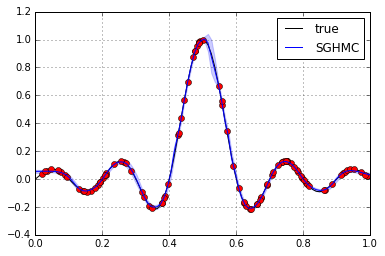

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pysgmcmc.diagnostics.objective_functions import sinc
from pysgmcmc.models.bayesian_neural_network import BayesianNeuralNetwork, SamplingMethod


## Set up data ##
rng, n_datapoints = np.random.RandomState(np.random.randint(0, 10000)), 100
X_train = np.array([rng.uniform(0., 1., 1) for _ in range(n_datapoints)])
y_train = sinc(X_train)

X_test = np.linspace(0, 1, 100)[:, None]
y_test = sinc(X_test)

g = tf.Graph()

session = tf.InteractiveSession(graph=g)
with g.as_default():
    model = BayesianNeuralNetwork(
        session=session, batch_size=20, sampling_method=SamplingMethod.SGHMC,
        learning_rate=np.sqrt(1e-4), mdecay=0.05, 
        burn_in_steps=3000, n_iters=50000, 
        normalize_input=True, normalize_output=True,
    )
    model.train(X_train, y_train)
    prediction_mean, prediction_variance = model.predict(X_test)

prediction_std = np.sqrt(prediction_variance)

plt.grid()

plt.plot(X_test[:, 0], y_test, label="true", color="black")
plt.plot(X_train[:, 0], y_train, "ro")

plt.plot(X_test[:, 0], prediction_mean, label="SGHMC", color="blue")
plt.fill_between(X_test[:, 0], prediction_mean + prediction_std, prediction_mean - prediction_std, alpha=0.2, color="blue")

plt.legend()
plt.show()
